In [4]:
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:


import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import optax

from markovsbi.tasks import get_task
from markovsbi.utils.sde_utils import init_sde
from markovsbi.models.simple_scoremlp import build_score_mlp, precondition_functions
from markovsbi.models.train_utils import build_batch_sampler,build_loss_fn

In [6]:
jax.devices()

[CudaDevice(id=0)]

In [7]:
key = jax.random.PRNGKey(0)

In [8]:
task = get_task("lotka_volterra", proposal="pred")
prior = task.get_prior()
simulator = task.get_simulator()

In [6]:
thetas_pred = prior.sample(key, (100,))
x_pred = jax.vmap(lambda k, theta : simulator(k, theta,100))(jax.random.split(key+1, 100), thetas_pred)

In [58]:
x_pred_fine = jnp.concat([jax.vmap(lambda x: jnp.interp(jnp.linspace(0,1,1000), jnp.linspace(0,1,100), x))(x_pred[i].T).T for i in range(100)], axis=0)

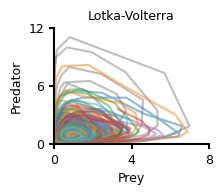

In [76]:
from markovsbi.bm.plot_utils import plot_metric_by_eval_steps, multi_plot, use_style

# Color palette tab20b

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5", "#ff9896"]

with use_style("pyloric"):
    fig = plt.figure(figsize=(2,1.5))
    for i in range(50):
        plt.plot(x_pred[i,:,0], x_pred[i,:,1], alpha=0.5, color=colors[i%10])

    ax = plt.gca()
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 12)
    ax.set_xticks([0,4,8])
    ax.set_yticks([0,6,12])
    ax.set_xlabel("Prey")
    ax.set_ylabel("Predator")
    ax.set_title("Lotka-Volterra")

    fig.savefig("phase_space_lv.svg")


In [59]:
x_pred_average = x_pred_fine.reshape(-1, x_pred.shape[-1])

def proposal(key):
    key, key2 = jax.random.split(key)
    idx = jax.random.randint(key, (), 0, x_pred_average.shape[0])
    x = x_pred_average[idx]
    eps = jax.random.normal(key2, x.shape)*0.3
    out = x + eps
    return jnp.where(out>0, out, x)

x0s = jax.vmap(proposal)(jax.random.split(key, 10_000))

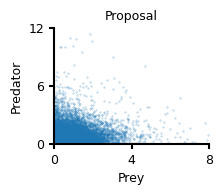

In [75]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(2,1.5))
    plt.scatter(x0s[:,0], x0s[:,1], alpha=0.5, s=0.1)

    ax = plt.gca()
    ax.set_xlabel("Prey")
    ax.set_ylabel("Predator")
    ax.set_title("Proposal")
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 12)
    ax.set_xticks([0,4,8])
    ax.set_yticks([0,6,12])

    fig.savefig("Proposal")


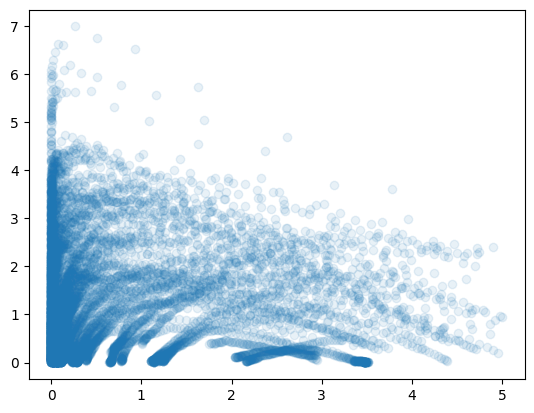

In [359]:
import numpy as np

# Loop through each 2D set in the 3D array and plot with colormap
for i, x in enumerate(x_pred):
    # Calculate some value to base the colormap on (e.g., the distance from the origin)
    # Create a scatter plot for each 2D set with a colormap based on distance
    plt.scatter(x[:, 0], x[:, 1],  color="C0", alpha=0.1)


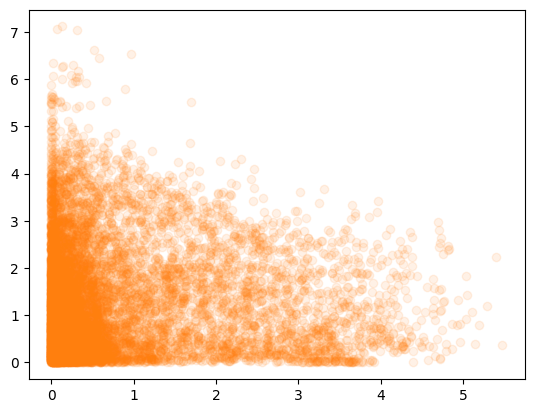

In [358]:
plt.scatter(x0s[:, 0], x0s[:, 1], color="C1", alpha=0.1)

In [130]:
x_pred_average = x_pred.reshape(-1, x_pred.shape[-1])

def proposal(key):
    key, key2 = jax.random.split(key)
    idx = jax.random.randint(key, (), 0, x_pred_average.shape[0])
    x = x_pred_average[idx]
    eps = jax.random.normal(key2, x.shape)*0.5
    out = x + eps
    return jnp.where(out>0, out, x)

In [198]:
x0s = jax.vmap(proposal)(jax.random.split(key, 95_000))

data = task.get_data(key, 95_000, 2)

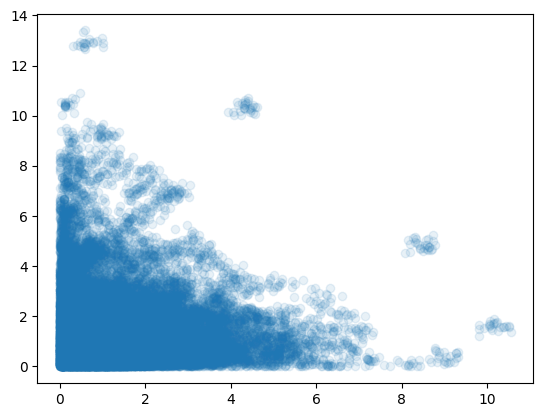

In [199]:
plt.scatter(data["xs"][:,0,0], data["xs"][:,0,1], alpha=0.1)